# **Importing Libraries**

In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import eli5
import shap
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# **Read and Loading the Dataset**

In [2]:
#Loading the Data
df=pd.read_csv("Training Dataset.csv")

# **Exploratory Data Analysis**

In [3]:
#Exploring the data
#Checking the top 5 rows of data
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
#Checking the size of Dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [4]:
df.nunique()

Loan_ID              614
Gender                 2
Married                2
Dependents             4
Education              2
Self_Employed          2
ApplicantIncome      505
CoapplicantIncome    287
LoanAmount           203
Loan_Amount_Term      10
Credit_History         2
Property_Area          3
Loan_Status            2
dtype: int64

In [16]:
df["Self_Employed"].unique()

array(['No', 'Yes', nan], dtype=object)

In [15]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [6]:
#Dropping null values
data =df.dropna()
data.shape

(480, 13)

# **Data PreProcessing And Visualization**

In [7]:
#Setting Object Data Types
obj = (data.dtypes == 'object')

In [8]:
#Dropping 'Loan_ID' column as it have unique values and are not related with any other column.
data.drop(['Loan_ID'], axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Converting categorical values to numerical value.

In [9]:
#Label_encoder
label_encoder = preprocessing.LabelEncoder()
obj = (data.dtypes == 'object')
for col in list(obj[obj].index):
    data[col] = label_encoder.fit_transform(data[col])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
#Checking the Data Columns
obj = (df.dtypes == 'object')
print("Categorical Variables:", len(list(obj[obj].index)))

Categorical Variables: 8


# **Data Visualisation**

<AxesSubplot:>

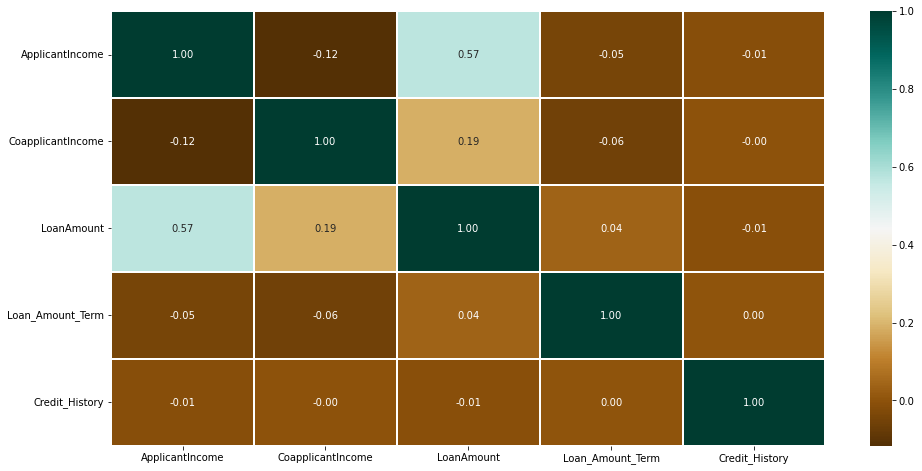

In [11]:
plt.figure(figsize=(16,8))
sns.heatmap(df.corr(), cmap='BrBG', fmt='.2f', linewidth=2, annot=True)

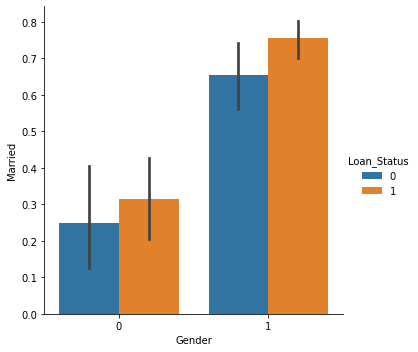

In [12]:
sns.catplot(x='Gender', y='Married', hue='Loan_Status', kind='bar', data=data)

There are missing values. But we will try to proceed further to see how the model works.

# **Splitting the DataSet**

In [13]:
X = data.drop(['Loan_Status'], axis=1)
Y = data['Loan_Status']
X.shape, Y.shape

((480, 11), (480,))

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((384, 11), (96, 11), (384,), (96,))

# **Model Training & Evaluation**

We will use 4 Models for this problem.
1. KNeighbors Classifiers
2. Random Forest Classifiers
3. SupportVector Classifiers (SVC)
4. Logistics Regression

In [15]:
knnc = KNeighborsClassifier(n_neighbors = 3)
rfc = RandomForestClassifier(n_estimators = 7, criterion = 'entropy', random_state=7)
svc = SVC()
lrc = LogisticRegression()

for c in (rfc, knnc, svc, lrc):
    c.fit(X_train, Y_train)
    Y_pred = c.predict(X_train)
    print("Accuracy of ", c.__class__.__name__, '=', 100*metrics.accuracy_score(Y_train, Y_pred))

Accuracy of  RandomForestClassifier = 96.875
Accuracy of  KNeighborsClassifier = 78.125
Accuracy of  SVC = 71.09375
Accuracy of  LogisticRegression = 82.8125


**Cross - Validation**

In [16]:
my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', RandomForestClassifier(n_estimators=100,
                                                              random_state=0))
                             ])
# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(my_pipeline, X, Y,
                              cv=5,
                              scoring='neg_mean_absolute_error')
print("MAE scores:\n", scores)

MAE scores:
 [0.20833333 0.23958333 0.1875     0.1875     0.1875    ]


In [17]:
print("Average MAE score (across experiments):")
print(scores.mean())

Average MAE score (across experiments):
0.20208333333333334


In [18]:
my_model = RandomForestClassifier(n_estimators=7,
                                  random_state=0).fit(X_train, Y_train)

# **Explainability**

In [19]:
#Feature Importance
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(my_model, random_state=1).fit(X_train, Y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

Weight,Feature
0.2094 ± 0.0222,Credit_History
0.0865 ± 0.0152,ApplicantIncome
0.0839 ± 0.0190,LoanAmount
0.0792 ± 0.0167,Property_Area
0.0719 ± 0.0142,Married
0.0557 ± 0.0112,Dependents
0.0495 ± 0.0093,CoapplicantIncome
0.0323 ± 0.0026,Loan_Amount_Term
0.0203 ± 0.0021,Gender
0.0161 ± 0.0061,Education


Here we can see the feature which is important for the model in predictions.

In [20]:
row_to_show = 2
data_for_prediction = X_train.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)


my_model.predict_proba(data_for_prediction_array)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


array([[0.14285714, 0.85714286]])

In [21]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

In [22]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

Summary Plot

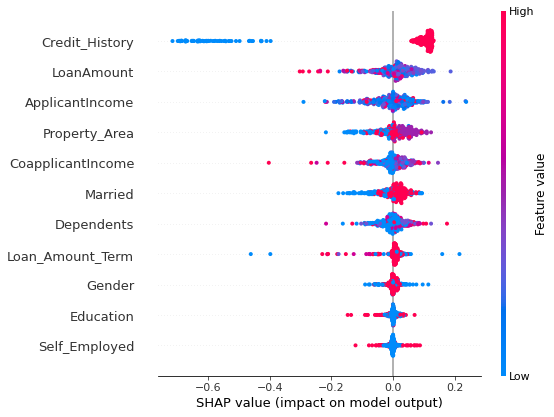

In [23]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_train)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], X_train)

SHAP Dependence Contribution Plots

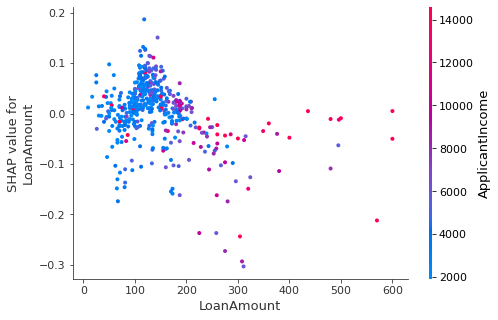

In [24]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X)

# make plot.
shap.dependence_plot('LoanAmount', shap_values[1], X, interaction_index="ApplicantIncome")

In [25]:
import pickle
pickle_out = open("model.pkl","wb")
pickle.dump(my_model, pickle_out)
pickle_out.close()